# Coding Attention Mechanisms

Attention mechanisms allows the model to focus on the more important parts.

This is a roadmap of how this will be.

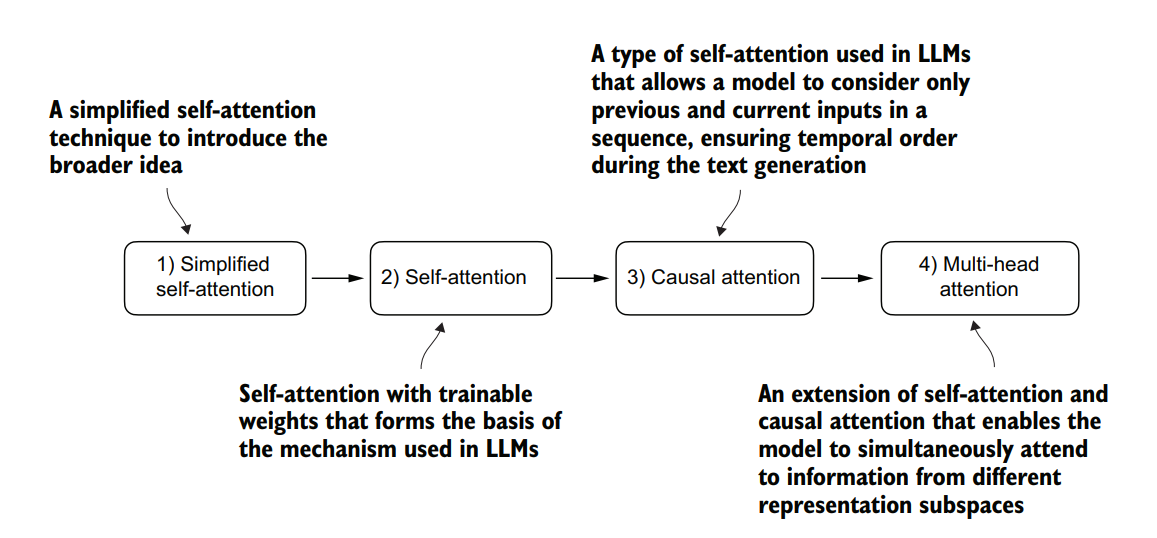

Focus attention mechanisms are important as we cant simply translate elements word by word due to grammatical structures. 

Moreover, if we wanted to predict the cat is playing, it is fierce, when predicting it, we should focus on the fact we are dealing with a cat.

For the previously mentioned statementes, it is important to implement this mechanisms.

 We will start with a simple mechanism and start working from there

 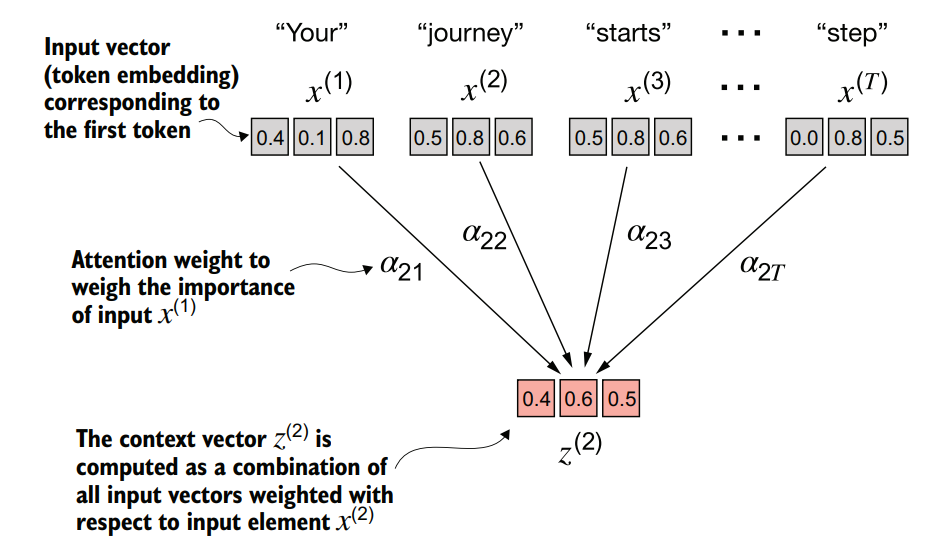

The importance of each input is determined by the attention weights.

We want to obtain a context vector for each element in the input.

In [13]:
# Making a short example
import torch
inputs = torch.tensor(
 [[0.43, 0.15, 0.89], # Your (x^1)
 [0.55, 0.87, 0.66], # journey (x^2)
 [0.57, 0.85, 0.64], # starts (x^3)
 [0.22, 0.58, 0.33], # with (x^4)
 [0.77, 0.25, 0.10], # one (x^5)
 [0.05, 0.80, 0.55]] # step (x^6)
)

# Attention scores are computed with the dot product
# As we are calculating the context vector for the second element, we use the second element for the dot product.

query = inputs[1] 
attn_scores_2 = torch.empty(inputs.shape[0]) # Creates a 1D empty tensor to store results
for i, x_i in enumerate(inputs):
 attn_scores_2[i] = torch.dot(x_i, query) # Dot prodcuts
print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


The dot product is used as a higher value provides a higher similarity as well.

Methods such as softmax are used to handle extreme values and to provide normalization.

Softmax provide positive values and higher values indicate a greater importance.

In [14]:
def softmax_naive(x):
 return torch.exp(x) / torch.exp(x).sum(dim=0)


attn_weights_2_naive = softmax_naive(attn_scores_2)
print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


To calculate the context vector, each of the tokens is multiplied with their corresponding attention weights which are then summed into the resulting vectors.

We will now compute the attention weights for all input tokens simultaneously.

In [15]:

attn_scores = torch.empty(6, 6) # Empty 6x6 matrix
for i, x_i in enumerate(inputs):
 for j, x_j in enumerate(inputs):
    attn_scores[i, j] = torch.dot(x_i, x_j)
print("For loop results: ", attn_scores)

# For efficiency, instead of for loops we will use matrix multiplications
attn_scores = inputs @ inputs.T
print("Matrix multiplication results. ", attn_scores)

# Normalizing the scores
attn_weights = torch.softmax(attn_scores, dim = -1) # Dim specifies the dimension along which the function will be applied on   
print("Normalized weights: ", attn_weights)

# Obtaining context vectors
all_context_vecs = attn_weights @ inputs
print("Context vectors: ",all_context_vecs)

For loop results:  tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
Matrix multiplication results.  tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
Normalized weights:  tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720]

Implementing self-attention with trainable weights.

This mechanism is called scaled dot-product attention

They introduce weight matrices which are updated during training.

We will first make the code, consequently, we will add it to our LLM architecture.

**Steps**

The three introduced trainable weight matrices are Wq Wk and Wv

Wq <- query vector  q = Wq * x  What we are looking for
- A query is analogous to a search query in a database. It represents the current item
(e.g., a word or token in a sentence) the model focuses on or tries to understand.
The query is used to probe the other parts of the input sequence to determine how
much attention to pay to them.

Wk <- key vector   k = Wk * x What we are comparing to 
- The key is like a database key used for indexing and searching. In the attention mechanism, each item in the input sequence (e.g., each word in a sentence) has an associated key. These keys are used to match the query. 


Wv <- value vector  v = Wv * x The information to return
- The value in this context is similar to the value in a key-value pair in a database. It
represents the actual content or representation of the input items. Once the model
determines which keys (and thus which parts of the input) are most relevant to the
query (the current focus item), it retrieves the corresponding values.


We have three matrices, as if we rather use just one, every word/token would be projected the same way regardless of whether it's being used to ask for information (query), store information (key), or provide information (value).

Attention scores will be calculated as a dot product of the key and query values, this provids a score of how much focus our model should put on that specific word. The query value is constant for all the operations, all wors have the same value.

The key vector is constant because we're asking:
"How relevant is each token  to the token 'journey'?"

Applying softmax we obtain the desired weights

The context vector will be obtained as the previous weights times the value vectors.

In [22]:
# Computing a single context vector
x_2 = inputs[1] # Second element from our inputs matrices
d_in = inputs.shape[1] # Input size, this is 3 due to the size of the word
d_out = 2 # Output size

# Input and output are usually the same, this is just for demonstration purposes

# Initializing the weight matrices
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False) # If we were to do training, requires grad = T
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

# Obtaining the vector values for the second input
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

# Obtaining for all values
keys = inputs @ W_key
values = inputs @ W_value
query = inputs @ W_query

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

# Attention score for the second element
keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
print("Attention score for the second element: ",attn_score_22)

# Attention scores for all elements
attn_scores_2 = query_2 @ keys.T
print("Attention scores for all elements: ",attn_scores_2)

# Attention weights (normalized attention scores)
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1) # Softmax, square root is used to avoid high numbers or close to 0
print("Attention weights: ", attn_weights_2)

# Obtaining the context vectors
context_vec_2 = attn_weights_2 @ values
print("Context vectors: ", context_vec_2)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])
Attention score for the second element:  tensor(1.8524)
Attention scores for all elements:  tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])
Attention weights:  tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])
Context vectors:  tensor([0.3061, 0.8210])


Brief scheme of what we just did



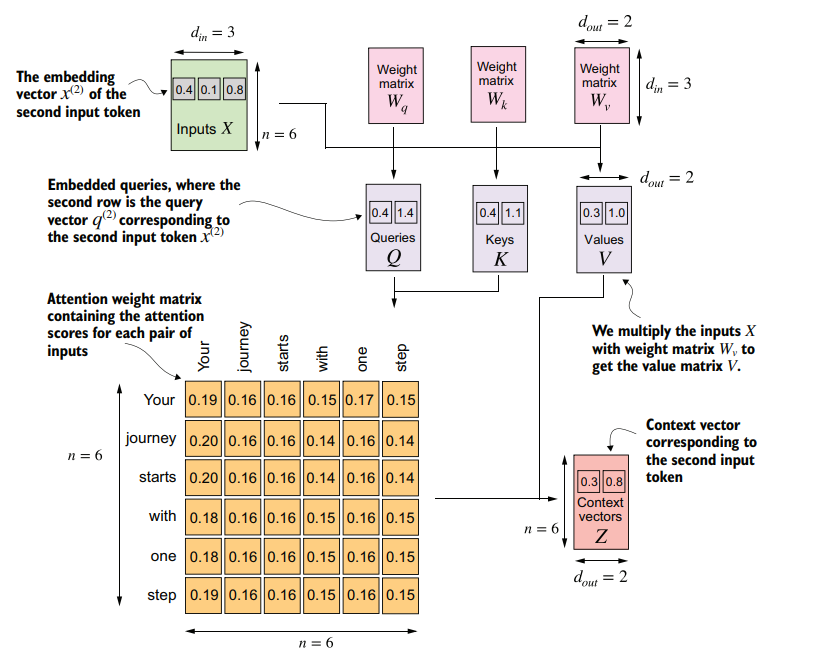

We will want to compute all context vectors.

Therefore, we will now implement a Python class to do so.


**Implementing a Python class**

In [25]:
import torch.nn as nn
class SelfAttention_v1(nn.Module):
    def __init__(self, d_in: int, d_out: int):
        super().__init__()
        """Init method for the class
        d_in: Size of the input
        d_out: Size of the output"""
        # Initiating the trainable matrices
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        # Obtaining keys, queries, values
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        # Obtaining attention scores
        attn_scores = queries @ keys.T # omega

        # Applying softmax
        attn_weights = torch.softmax(
        attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        # Obtaining context vectors
        context_vec = attn_weights @ values
        return context_vec

In [ ]:
# Testing our new class
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))
# Six elements as inputs has six embedding vectors

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [ ]:
# An improved version to this, would be to use nn.Linear as it has an optimized weight initialization scheme, leading to a more stable
# and effective model training, moreover, it is more efficient on matrix multiplications.

class SelfAttention_v2(nn.Module):
 def __init__(self, d_in, d_out, qkv_bias=False):
    super().__init__()
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

 def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(
        attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec
 
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

# The results are different as nn.Linear stores the matrices transposed.

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


**Causal Attention**

One of our main concerns, is that our model has access to the whole input, therefore future words. This greatly affects prediction, and we have to use methods such as masked or causal attention to only use past and current inputs.

To do so, at each token, we mask future tokens. Therefore, we have the attention scores matrix with 0s above the diagonal.

To do so, we can apply softmax to the attention scores, empty cells above the diagonal and normalize it

After masking and renormalization, the distribution of attention
weights is as if it was calculated only among the unmasked positions to begin with.
This ensures there’s no information leakage from future (or otherwise masked)
tokens as we intended

In [ ]:
# Computing attention weights with the previous softmax function
queries = sa_v2.W_query(inputs) # Queries
keys = sa_v2.W_key(inputs) # Keys
attn_scores = queries @ keys.T # Attention scores
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1) # Attention weights
print("Attention weights: ", attn_weights)

# To obtain 0s above the diagonal, we use tril PyTorch function. Tril returns the lower diagonal matrix
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length)) # Matrix of 1s on the lower part including diagonal

# Multiplying it
masked_simple = attn_weights*mask_simple
print("Masked simple matrix: ", masked_simple)

# Normalizing the rows (dividing by the total sum)
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print("Normalized masked simple matrix: ", masked_simple_norm)


Attention weights:  tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)
Masked simple matrix:  tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.

In [37]:
# A simpler approach to this would be to have -Inf at aobve cells instead of 0s
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print("Matrix with -Inf: ",masked)

attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print("Attention weights",attn_weights)

Matrix with -Inf:  tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)
Attention weights tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


**Dropout**


Process where randomly selected layers are ignored only during training, effectively dropping them out, this prevents overfitting.
We will apply this process after computing the attention weights

In [ ]:
# Brief example
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # As we use a dropout rate of 0.5, we are scaling the remaining elements by x2
example = torch.ones(6, 6)
print("Dropout example: ", dropout(example))

torch.manual_seed(123)
print("Dropout weights: ",dropout(attn_weights))


tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])
Dropout weights:  tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


**Implementing a compact causal attention class**

In [40]:
# Ensuring our code can handle batches of more than one input
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) 

torch.Size([2, 6, 3])


In [46]:
# Causal Attention class
class CausalAttention(nn.Module):
    def __init__(self, d_in: int, d_out: int, context_length: int,
        dropout: float, qkv_bias=False):
        super().__init__()
        """Init method
        d_in = input embedding size
        d_out = output embedding size
        context_length = max number of tokens in a sentence
        dropout = droput rate
        qkv_bias = whether to add bias"""
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # Implemented dropout layer
        self.dropout = nn.Dropout(dropout)

        # Upper triangular matrix for masking
        self.register_buffer(
        'mask',
        torch.triu(torch.ones(context_length, context_length),
        diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape # x.shape = [batch_size, sequence_length, embedding_dim]

        # Obtaining the different vectors
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # Attention scores
        attn_scores = queries @ keys.transpose(1, 2)

        # Causal mask for future tokens
        attn_scores.masked_fill_(
        self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)

        # Softmax
        attn_weights = torch.softmax(
        attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        # Dropout
        attn_weights = self.dropout(attn_weights)

        # Context vectors
        context_vec = attn_weights @ values
        return context_vec

**Multi-Head attention**

Refers to diving the attention into multiple independent heads.

Firstly, we will stack our single-head layers, next, we will implement a more complex yet more efficient approach.


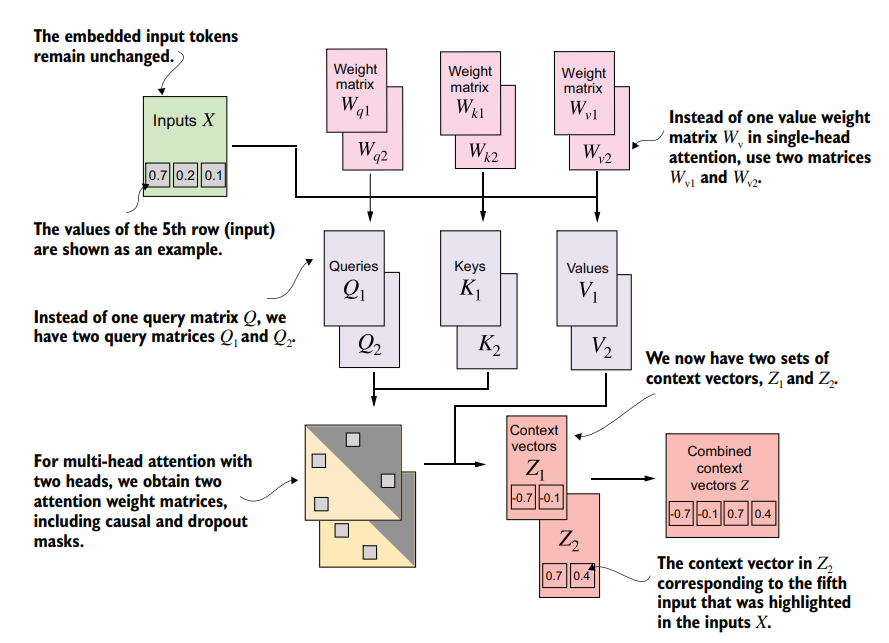

In [45]:
# A wrapper class to implement multi-head attention
class MultiHeadAttentionWrapper(nn.Module):
 def __init__(self, d_in, d_out, context_length,
    dropout, num_heads, qkv_bias=False):
    super().__init__()
    # Using the previous implemented class
    # Creates a list of CausalAttentionClass
    self.heads = nn.ModuleList(
    [CausalAttention(
    d_in, d_out, context_length, dropout, qkv_bias
    )
    for _ in range(num_heads)]
    )
 def forward(self, x):
    # Computes the values and concatenates them
    return torch.cat([head(x) for head in self.heads], dim=-1)

In [ ]:
# Using an example to test this
torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2

mha = MultiHeadAttentionWrapper(
 d_in, d_out, context_length, 0.0, num_heads=2
)
context_vecs = mha(batch)
print("Context vectors: ",context_vecs)
print("context_vecs.shape:", context_vecs.shape)

# THis implementation can be improved processing the heads in parallel

Context vectors:  tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


**Improved approach**


We will merge both classes

In [ ]:
class MultiHeadAttention(nn.Module):
 def __init__(self, d_in, d_out,
    context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()

    assert (d_out % num_heads == 0), \
    "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads # Makes sure each attention head has equal dimensions

    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out) # Layer to combine outpute
    self.dropout = nn.Dropout(dropout)

    self.register_buffer(
    "mask",
    torch.triu(torch.ones(context_length, context_length),
    diagonal=1)
    )


 def forward(self, x):
    b, num_tokens, d_in = x.shape # b <- batch size, num_tokens <- sequence length, d_in <- input embedding

    # shape = [b,num_tokens, d_out] where d_out = num_heads * head_dim
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    # Split the values into Heads, shape = [b, num_tokens, num_heads, head_dim]
    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(
    b, num_tokens, self.num_heads, self.head_dim
    )

    # As we are using nn.Linear we need to transpose our matrices
    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2)

    # Computes dot product for each head
    attn_scores = queries @ keys.transpose(2, 3)

    # Masking
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]  # Mask fixed to token number
    attn_scores.masked_fill_(mask_bool, -torch.inf) # Uses mask to fill attention scores

    # Softmax + Dropout
    attn_weights = torch.softmax(
    attn_scores / keys.shape[-1]**0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)

    # Context vector
    context_vec = (attn_weights @ values).transpose(1, 2)

    # Combine all heads
    context_vec = context_vec.contiguous().view(
    b, num_tokens, self.d_out
    )
    # Mix information to a single simple layer
    context_vec = self.out_proj(context_vec)
    return context_vec

In [53]:
# Testing our new class
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


**SUMMARY**


 Attention mechanisms transform input elements into enhanced context vector
representations that incorporate information about all inputs.

 A self-attention mechanism computes the context vector representation as a
weighted sum over the inputs.

 In a simplified attention mechanism, the attention weights are computed via
dot products.

 A dot product is a concise way of multiplying two vectors element-wise and then
summing the products.

 Matrix multiplications, while not strictly required, help us implement computations more efficiently and compactly by replacing nested for loops.

 In self-attention mechanisms used in LLMs, also called scaled-dot product
attention, we include trainable weight matrices to compute intermediate transformations of the inputs: queries, values, and keys.

 When working with LLMs that read and generate text from left to right, we add
a causal attention mask to prevent the LLM from accessing future tokens.

 In addition to causal attention masks to zero-out attention weights, we can add
a dropout mask to reduce overfitting in LLMs.

 The attention modules in transformer-based LLMs involve multiple instances of
causal attention, which is called multi-head attention.

 We can create a multi-head attention module by stacking multiple instances of
causal attention modules.

 A more efficient way of creating multi-head attention modules involves batched
matrix multiplications.